## Semester 1 Project Submission

Please fill out:
* Student name: 
* Instructor name: 


In [1]:
# Your code here - remember to use markdown cells for comments as well!

In [15]:
import pandas as pd
import sqlite3
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.api as sm
import numpy as np
%matplotlib inline
# You'll need to unzip the db locally.
conn = sqlite3.connect('zippedData/im.db')

# Habib Khadri

# Nick Kirbabas

In [3]:
df_budget = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
df_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [4]:
df_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', delimiter='\t')

In [5]:
df_info.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [6]:
df_info.isna().sum()

id                 0
synopsis          62
rating             3
genre              8
director         199
writer           449
theater_date     359
dvd_date         359
currency        1220
box_office      1220
runtime           30
studio          1066
dtype: int64

This file has many null values with some columns almost completely unusable


 ## SQL Exploration



Narrowing down list of directors to ones that have over 10 movies (want experienced directors) and have films in the US, our largest target audience

In [7]:
pd.read_sql('''
SELECT distinct primary_name
FROM principals
JOIN persons USING (person_id)
JOIN movie_akas USING (movie_id)
WHERE category == 'director' AND region == 'US'
GROUP BY primary_name
HAVING count(person_id) > 10
ORDER BY count(person_id) DESC
''',conn)

,primary_name
0,Ansel Faraj
1,Larry Rosen
2,Charlie Minn
3,Jon M. Chu
4,Dustin Ferguson
...,...
94,Deon Taylor
95,Dennis Dugan
96,Dennis Devine
97,Darren Lynn Bousman


Adding previous query as subquery to find the average rating of the directors' movies. This should help us in our recommendation of which directors to choose for the film

In [8]:
pd.read_sql('''
Select persons.primary_name as Director, avg(averagerating) as ratings
from principals 
JOIN persons ON persons.person_id = principals.person_id
JOIN movie_basics as mb ON mb.movie_id = principals.movie_id
JOIN movie_ratings as mr ON mr.movie_id = mb.movie_id
WHERE category == 'director' AND persons.death_year is NULL AND primary_name IN 
(
SELECT distinct primary_name
FROM principals
JOIN persons USING (person_id)
JOIN movie_akas USING (movie_id)
WHERE category == 'director' AND region == 'US'
GROUP BY primary_name
HAVING count(person_id) > 10
ORDER BY count(person_id) DESC
)
GROUP BY Director
HAVING sum(numvotes) > 5000
ORDER BY ratings DESC
LIMIT 15
''',conn )

,Director,ratings
0,Christopher Nolan,8.425000
1,Anthony Russo,8.225000
2,Joe Russo,7.820000
3,Martin Scorsese,7.657143
4,J.J. Abrams,7.566667
5,Steven Spielberg,7.228571
6,Alex Gibney,7.173333
7,Justin Lin,7.166667
8,Joseph Kosinski,7.166667
9,James Wan,7.116667


(NOTE: adding a conditional to the sum of votes on each movie prevents documentaries, which have high ratings but low votes, from skewing results)

Similar query as previous but this time looking at Actors

In [9]:
pd.read_sql('''
Select persons.primary_name as Actor, avg(averagerating) as ratings
from principals 
JOIN persons ON persons.person_id = principals.person_id
JOIN movie_basics as mb ON mb.movie_id = principals.movie_id
JOIN movie_ratings as mr ON mr.movie_id = mb.movie_id
WHERE category == 'actor' AND persons.death_year is NULL AND primary_name IN 
(
SELECT distinct primary_name
FROM principals
JOIN persons USING (person_id)
JOIN movie_akas USING (movie_id)
WHERE category == 'actor' AND region == 'US'
GROUP BY primary_name
HAVING count(person_id) > 10
ORDER BY count(person_id) DESC
)
GROUP BY Actor
HAVING sum(numvotes) > 1000
ORDER BY ratings DESC
LIMIT 15
''',conn )

,Actor,ratings
0,Leonardo DiCaprio,8.090000
1,Robert Downey Jr.,7.530769
2,Andrew Garfield,7.472727
3,Ian McKellen,7.412500
4,Tom Hardy,7.361538
5,Mark Ruffalo,7.323529
6,Brad Pitt,7.208333
7,Hugh Jackman,7.207692
8,Jeremy Renner,7.181818
9,Richard Armitage,7.172727


And now actresses 

In [10]:
pd.read_sql('''
Select persons.primary_name as Actress, avg(averagerating) as ratings
from principals 
JOIN persons ON persons.person_id = principals.person_id
JOIN movie_basics as mb ON mb.movie_id = principals.movie_id
JOIN movie_ratings as mr ON mr.movie_id = mb.movie_id
WHERE category == 'actress' AND persons.death_year is NULL AND primary_name IN 
(
SELECT distinct primary_name
FROM principals
JOIN persons USING (person_id)
JOIN movie_akas USING (movie_id)
WHERE category == 'actress' AND region == 'US'
GROUP BY primary_name
HAVING count(person_id) > 10
ORDER BY count(person_id) DESC
)
GROUP BY Actress
HAVING sum(numvotes) > 1000
ORDER BY ratings DESC
LIMIT 15
''',conn )

,Actress,ratings
0,Amy Adams,7.128571
1,Bryce Dallas Howard,7.075000
2,Helena Bonham Carter,7.018182
3,Scarlett Johansson,6.992308
4,Rachel McAdams,6.933333
5,Rooney Mara,6.929412
6,Zoe Saldana,6.925000
7,Margot Robbie,6.915385
8,Jennifer Lawrence,6.811111
9,Cate Blanchett,6.800000


In [16]:
#Once Andrew merges his branch with the master this section will not
#need to be in section
from datetime import datetime
tn_df = pd.read_csv("zippedData/tn.movie_budgets.csv.gz").drop("id", axis = 1)
tn_df["production_budget"].replace(["\$",","], "", regex = True, inplace = True)
tn_df["domestic_gross"].replace(["\$",","], "", regex = True, inplace = True)
tn_df["worldwide_gross"].replace(["\$",","], "", regex = True, inplace = True)

# convert budget and profit columns to numeric
cols = ["production_budget","domestic_gross","worldwide_gross"]
tn_df[cols] = tn_df[cols].apply(pd.to_numeric)

# created new columns to grab date information (day, week of year, month, etc.)
tn_df["datetime"] = [datetime.strptime(d, "%b %d, %Y") for d in tn_df["release_date"]]
tn_df["release_weeknum"] = [d.isocalendar()[1] for d in tn_df["datetime"]]
tn_df["release_weekday"] = [d.weekday() for d in tn_df["datetime"]]
tn_df["release_month"] = [d.month for d in tn_df["datetime"]]
tn_df["release_year"] = [d.year for d in tn_df["datetime"]]

# calc movie seasonal info (came out on a weekend, calander season)
tn_df["weekend"]  = np.where((tn_df["release_weekday"]== 5) |
                                  (tn_df["release_weekday"]== 6),
                                    1, 0)   


In [17]:
#This section is the same as previous, unnecessary once Andrew's is merged
bom_df = pd.read_csv("zippedData/bom.movie_gross.csv.gz")
bom_df["foreign_gross"].replace(",","", regex = True, inplace = True)
bom_df["foreign_gross"] = pd.to_numeric(bom_df["foreign_gross"])
bom_df["foreign_gross"].fillna(bom_df["foreign_gross"].median(), 
                               inplace = True)
bom_df["domestic_gross"].fillna(bom_df["domestic_gross"].median(), 
                                inplace = True)
bom_df.dropna(subset = ["studio"], inplace = True)

imdb_df = pd.read_sql('''
SELECT *
FROM movie_basics
    INNER JOIN movie_ratings USING("movie_id")
''',conn)

In [18]:
imdb_df.dropna(subset = ["genres"], inplace = True)
#imdb_df.dropna(subset = ["primary_profession"], inplace = True)
imdb_df["runtime_minutes"] = imdb_df["runtime_minutes"].fillna(imdb_df["runtime_minutes"].mean())
imdb_df["genres_list"] = [gs.split(",") for gs in imdb_df["genres"]]
imdb_df["genres_count"] = [len(gs) for gs in imdb_df["genres_list"]]
#imdb_df["prof_list"] = [gs.split(",") for gs in imdb_df["primary_profession"]]
imdb_df = imdb_df[imdb_df["runtime_minutes"] <= 300]

imdb_df_c = imdb_df.merge(bom_df, how = "inner", 
                          left_on = ["primary_title", "start_year"], 
                          right_on = ["title","year"])
imdb_df_c2 = imdb_df_c.merge(tn_df, how = "inner", 
                             left_on = ["primary_title", "start_year"], 
                             right_on = ["movie","release_year"])


## Only difference between Andrew's code and mine with respect to dataframes ##
imdb_df_c = imdb_df.merge(tn_df, how = "inner", 
                          left_on = ["primary_title", "start_year"], 
                          right_on = ["movie","release_year"])

## Graphing the relationship between Movie Runtime and World Wide Net Profit

<ipython-input-32-171c35c76ba0>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


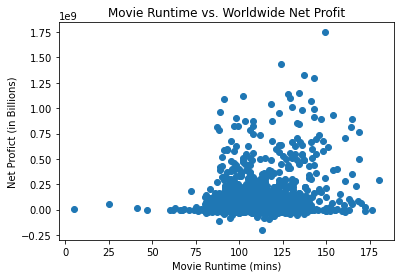

In [32]:
imdb_df_c['worldwide_net_profit'] = (imdb_df_c['worldwide_gross'] - 
                       imdb_df_c['production_budget'])
fig, ax = plt.subplots()
ax.scatter(imdb_df_c["runtime_minutes"], (imdb_df_c['worldwide_net_profit']))
ax.set_title("Movie Runtime vs. Worldwide Net Profit")
ax.set_xlabel("Movie Runtime (mins)")
ax.set_ylabel("Net Profict (in Billions)")
fig.show()

(0.2846470040251809, 2.7886684481126725e-29)


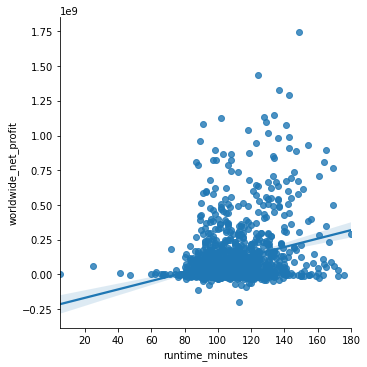

In [33]:
sns.lmplot(x ='runtime_minutes', y ='worldwide_net_profit', data = imdb_df_c)
print(stats.pearsonr(imdb_df_c['runtime_minutes'], worldwide_net_profit))

The correlation coefficient of ~0.285 shows there is a weak positive correlation between runtime and net profit.

## Linear Regression of our proposed indicators

In [24]:
predictors = ['runtime_minutes', 'genres_count', 'production_budget_y']
x = imdb_df_c2[predictors]
y = (imdb_df_c2['worldwide_gross_y'] - imdb_df_c2['production_budget_y'])

x = sm.add_constant(x)

result = sm.OLS(y, x).fit()
 
# printing the summary table
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     397.1
Date:                Tue, 16 Aug 2022   Prob (F-statistic):          1.45e-189
Time:                        16:37:48   Log-Likelihood:                -30229.
No. Observations:                1496   AIC:                         6.047e+04
Df Residuals:                    1492   BIC:                         6.049e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -5.309e+07   2

# Seerat Mutneja

# Sidhya Raman

# Douglas Riggs

In [ ]:
pd.read_sql('''
SELECT 
    name
FROM 
    sqlite_schema
WHERE 
    type ='table' AND 
    name NOT LIKE 'sqlite_%';
''',conn)

# Andrew Yang